In [ ]:
!pip install pymoo

In [2]:
import pickle as p
import numpy as np
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
import os

plt.rc('legend', fontsize=13)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=13)
plt.rcParams["font.family"] = "serif"

## Summarize results

In [3]:
def get_hashKey(arch):
    return ''.join(map(str, arch))

def find_the_better(x, y):
    if isinstance(x, list):
        x = np.array(x)
    if isinstance(y, list):
        y = np.array(y)
    sub_ = x - y
    x_better = np.all(sub_ <= 0)
    y_better = np.all(sub_ >= 0)
    if x_better == y_better:  # True - True
        return -1
    if y_better:  # False - True
        return 1
    return 0  # True - False

def get_front_0(F):
    l = len(F)
    r = np.zeros(l, dtype=np.int8)
    for i in range(l):
        if r[i] == 0:
            for j in range(i + 1, l):
                better_sol = find_the_better(F[i], F[j])
                if better_sol == 0:
                    r[j] += 1
                elif better_sol == 1:
                    r[i] += 1
                    break
    return r == 0

def calculate_IGD(af):
    af = np.array(af)
    af[:, 1] = (af[:, 1] - min_FLOPs) / (max_FLOPs - min_FLOPs)
    af = np.round(af, 4)
    igd_value = IGD_computing(af)
    return igd_value


def calculate_HV(af):
    hv_value = HV_computing(af)
    return np.round(hv_value / np.prod(reference_point), 6)

def evaluate(list_arch):
    F = []
    for arch in list_arch:
        hashKey = get_hashKey(arch)
        test_error = np.round(1 - benchmark_data['200'][hashKey]['test_acc'][-1], 4)
        efficiency_metric = np.round(benchmark_data['200'][hashKey]['FLOPs'], 4)
        f = [test_error, efficiency_metric]
        F.append(f)

    F = np.array(F)
    list_arch = np.array(list_arch)
    fr0 = get_front_0(F)
    AF = F[fr0]
    AF = np.unique(AF, axis=0)
    AS = list_arch[fr0]
    igd_value = calculate_IGD(AF)
    hv_value = calculate_HV(AF)
    best_test_acc = np.round((1 - np.min(AF[:, 0])) * 100, 2)
    opt_results = {
        'Approximation Set': AS,
        'Approximation Front': AF,
        'IGD': igd_value,
        'HV': hv_value,
        'Best testing accuracy': best_test_acc,
    }
    return opt_results



def summarize_results():
    list_variant = [
        'val_error', 'val_loss', 'train_loss',
        'synflow', 'jacov', 'snip', 'grad_norm', 'grasp', 'fisher',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS', 'E-TF-MOENAS-C'
    ]
    for variant in list_variant:
        print('Algorithm:', variant)
        algo_res_path = f'{RES_PATH}/NAS201-{dataset_abbrev}_{variant}'

        if not os.path.exists(algo_res_path):
           continue
        nEvals_all = []
        rt_all = []
        EA_all = []
        IGD_all = []
        HV_all = []
        list_exp = list(os.listdir(algo_res_path))
        for rid in list_exp:
            if rid == 'logging.txt':
                continue
            IGD_history = []
            HV_history = []
            EA_history = []

            exp_res_path = algo_res_path + f'/{rid}'

            nEvals_runningtime_each_gen = p.load(open(exp_res_path + '/#Evals_runningtime_each_gen.p', 'rb'))
            nEvals_runningtime_each_gen = np.array(nEvals_runningtime_each_gen)

            nEvals_history = (nEvals_runningtime_each_gen[:, 0].astype(int)).tolist()
            running_time_history = (nEvals_runningtime_each_gen[:, 1].astype(int) + 1).tolist()

            E_Archive_search_each_gen = p.load(open(exp_res_path + '/E_Archive_search_each_gen.p', 'rb'))
            for EA in E_Archive_search_each_gen:
                rs_evaluation = evaluate(EA['X'])

                ea = {
                    'X_lst': rs_evaluation['Approximation Set'],
                    'F_lst': rs_evaluation['Approximation Front'],
                }

                igd_value = rs_evaluation['IGD']
                hv_value = rs_evaluation['HV']

                EA_history.append(ea)
                IGD_history.append(igd_value)
                HV_history.append(hv_value)

            nEvals_all.append(nEvals_history)
            rt_all.append(running_time_history)
            EA_all.append(EA_history)
            IGD_all.append(IGD_history)
            HV_all.append(HV_history)

        nEvals_all = np.array(nEvals_all)
        rt_all = np.array(rt_all)
        IGD_all = np.array(IGD_all)

        nEvals_all = np.array(nEvals_all)
        rt_all = np.array(rt_all)
        IGD_all = np.array(IGD_all)
        HV_all = np.array(HV_all)

        rs_all = {
            'nEvals_all': nEvals_all,
            'running_time_all': rt_all,
            'EA_all': EA_all,
            'IGD_all': IGD_all,
            'HV_all': HV_all,
        }
        p.dump(rs_all, open(f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}.p', 'wb'))


def processing_results():
    list_variant = [
        'val_error', 'val_loss', 'train_loss',
        'synflow', 'jacov', 'snip', 'grad_norm', 'grasp', 'fisher',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS', 'E-TF-MOENAS-C'
    ]

    for variant in list_variant:
        print('Algorithm:', variant)
        raw_res = p.load(open(f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}.p', 'rb'))

        best_arch_found = []
        final_EA = []
        final_IGD = []
        final_HV = []
        final_running_time = []

        n_run = len(raw_res['EA_all'])
        for i in range(n_run):
            EA = raw_res['EA_all'][i][-1]
            F = EA['F_lst']
            best_arch = np.round((1 - np.min(F[:, 0])) * 100, 2)
            IGD_value = raw_res['IGD_all'][i][-1]
            HV_value = raw_res['HV_all'][i][-1]
            rt = raw_res['running_time_all'][i][-1]

            best_arch_found.append(best_arch)
            final_IGD.append(IGD_value)
            final_HV.append(HV_value)
            final_running_time.append(rt)
            final_EA.append(EA)

        rs_final = {
            'best_arch_found': best_arch_found,
            'final_EA': final_EA,
            'final_IGD': final_IGD,
            'final_HV': final_HV,
            'running_time_avg': int(np.mean(final_running_time)) + 1
        }
        p.dump(rs_final, open(f'{RES_PATH}/{variant}_{dataset_abbrev}.p', 'wb'))


## Visualize results

In [4]:
def visualize_mean_std(obj0_mean, obj1_mean, obj1_std, label, line):
    color = line[0]
    style = line[1]
    ax.plot(obj0_mean, obj1_mean, c=color, ls=style, label=label, linewidth=1.5)
    ax.fill_between(obj0_mean, obj1_mean - obj1_std, obj1_mean + obj1_std, alpha=0.1, fc=color)

def visualize_xaxis_nEvals():
    list_variant = [
        'train_loss',
        'synflow',
        'jacov',
        'E-TF-MOENAS',
        'E-TF-MOENAS-C'
    ]

    labels = [
        'NSGAII (train-loss)',
        'NSGAII (synflow)',
        'NSGAII (jacov)',
        'E-TF-MOENAS (Ours)',
        'E-TF-MOENAS-C (Ours)'
    ]

    colors = {
        'NSGAII (train-loss)': ['green', '-.'],
        'NSGAII (synflow)': ['tab:orange', '-.'],
        'NSGAII (jacov)': ['purple', '-.'],
        'E-TF-MOENAS (Ours)': ['red', '-.'],
        'E-TF-MOENAS-C (Ours)': ['brown', '-.'],
    }

    list_raw_res = [f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}.p' for variant in list_variant]

    algo_hv_mean = []
    algo_hv_std = []

    algo_igd_mean = []
    algo_igd_std = []

    algo_nEvals = []
    for raw_res in list_raw_res:
        res = p.load(open(raw_res, 'rb'))
        IGD_all = res['IGD_all']
        HV_all = res['HV_all']
        nEvals = res['nEvals_all'][0]

        HV_mean = np.mean(HV_all, axis=0)
        HV_std = np.std(HV_all, axis=0)

        IGD_mean = np.mean(IGD_all, axis=0)
        IGD_std = np.std(IGD_all, axis=0)

        algo_hv_mean.append(HV_mean)
        algo_hv_std.append(HV_std)

        algo_igd_mean.append(IGD_mean)
        algo_igd_std.append(IGD_std)

        algo_nEvals.append(nEvals)

    ends = [20, 100, 1000, 3000]

    for i in range(len(algo_igd_mean)):
        if metric == 'IGD':
            visualize_mean_std(algo_nEvals[i], algo_igd_mean[i], algo_igd_std[i], labels[i], line=colors[labels[i]])
        else:
            visualize_mean_std(algo_nEvals[i], algo_hv_mean[i], algo_hv_std[i], labels[i], line=colors[labels[i]])

    ax.set_xscale('log')
    ax.set_xticks(ends)
    ax.get_xaxis().set_major_formatter(FormatStrFormatter('%.2d'))
    ax.set_xlabel('#Evals')
    ax.set_ylabel(metric)

    plt.grid(True, linestyle='--')
    plt.title('NASBench201', fontsize=20)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)

    plt.savefig(f'{RES_PATH}/nEvals_{metric}_201_{dataset_abbrev}.jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)

def visualize_xaxis_hours():
    list_variant = [
        'train_loss',
        'synflow',
        'jacov',
        'E-TF-MOENAS',
        'E-TF-MOENAS-C'
    ]

    labels = [
        'NSGAII (train-loss)',
        'NSGAII (synflow)',
        'NSGAII (jacov)',
        'E-TF-MOENAS (Ours)',
        'E-TF-MOENAS-C (Ours)'
    ]

    colors = {
        'NSGAII (train-loss)': ['green', '-.'],
        'NSGAII (synflow)': ['tab:orange', '-.'],
        'NSGAII (jacov)': ['purple', '-.'],
        'E-TF-MOENAS (Ours)': ['red', '-.'],
        'E-TF-MOENAS-C (Ours)': ['brown', '-.'],
    }

    list_raw_res = [f'{RES_PATH}/raw_results_{variant}_{dataset_abbrev}.p' for variant in list_variant]

    algo_hv_mean = []
    algo_hv_std = []

    algo_igd_mean = []
    algo_igd_std = []

    algo_rt = []

    for raw_res in list_raw_res:
        res = p.load(open(raw_res, 'rb'))
        IGD_all = res['IGD_all']
        HV_all = res['HV_all']
        rt_all = res['running_time_all']

        HV_mean = np.mean(HV_all, axis=0)
        HV_std = np.std(HV_all, axis=0)

        IGD_mean = np.mean(IGD_all, axis=0)
        IGD_std = np.std(IGD_all, axis=0)
        rt_mean = np.round(np.mean(rt_all, axis=0)/3600, 4)

        algo_hv_mean.append(HV_mean)
        algo_hv_std.append(HV_std)

        algo_igd_mean.append(IGD_mean)
        algo_igd_std.append(IGD_std)

        algo_rt.append(rt_mean)

    ends = [0.0118, 0.0186, 0.6033, 1.623, 2.6864, 88.3908]

    for i in range(len(algo_igd_mean)):
        if metric == 'IGD':
            visualize_mean_std(algo_rt[i], algo_igd_mean[i], algo_igd_std[i], labels[i], line=colors[labels[i]])
        else:
            visualize_mean_std(algo_rt[i], algo_hv_mean[i], algo_hv_std[i], labels[i], line=colors[labels[i]])

    ax.set_xscale('log')
    ax.set_xticks(ends)
    ax.get_xaxis().set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlabel('GPUs Hours')
    ax.set_ylabel(metric)
    if metric == 'IGD':
        plt.legend(loc=1)
    else:
        plt.legend(loc=4)
    plt.xticks(rotation=90)

    plt.grid(True, linestyle='--')
    plt.title('NASBench201', fontsize=20)
    plt.savefig(f'{RES_PATH}/runtime_{metric}_201_{dataset_abbrev}.jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)

## T-Tests

In [13]:
alpha = 0.05


def return_IGD_HV(rs):
    return rs['final_IGD'], rs['final_HV']

def compare(x, y, name_x, name_y, metric='IGD', a=0.05):
    p_value = stats.ttest_ind(x, y)[-1]

    print(metric, name_x, name_y)
    print('p_value:', p_value)

    if np.isnan(p_value):
        p_value = 1
    if p_value <= a:
        mean_1 = np.mean(x)
        mean_2 = np.mean(y)
        std_1 = np.std(x)
        std_2 = np.std(y)
        cohen_d = (abs(mean_1 - mean_2)) / ((std_1 ** 2 + std_2 ** 2) / 2) ** (1 / 2)
        if cohen_d >= 0.8:
            effect_size = 'large'
        elif cohen_d >= 0.5:
            effect_size = 'medium'
        elif cohen_d >= 0.2:
            effect_size = 'small'
        else:
            effect_size = 'trivial'
        rs = np.mean(y) - np.mean(x)
        if metric in ['HV', 'best_arch_found']:
            rs *= -1
        if rs > 0:
            rs_compare = 'worse'
        else:
            rs_compare = 'better'
        print('Reject |', rs_compare, effect_size)
    print()

def print_mean_std(_all, round_pre=4):
    _mean = np.mean(_all, axis=0)
    _std = np.std(_all, axis=0)
    print(f'{np.round(_mean, round_pre)} ({np.round(_std, round_pre)})')

def print_running_time_avg(rs):
    try:
        print('Running Time (avg):', rs['running_time_avg'])
    except:
        pass

def print_best_arch_mean_std(rs):
    _mean = np.round(np.mean(rs['best_arch_found']), 2)
    _std = np.round(np.std(rs['best_arch_found']), 2)
    print(f'Best (mean & std): {_mean} ({_std})')

def run_t_test():
    print('Dataset:', dataset)

    list_variant = [
        'val_error', 'val_loss', 'train_loss',
        'moead-val_error', 'moead-val_loss', 'moead-train_loss',
        'synflow', 'jacov', 'snip', 'grad_norm', 'grasp', 'fisher',
        'ENAS_TFI', 'MOENAS_PSI', 'MOENAS_TF_PSI',
        'E-TF-MOENAS', 'E-TF-MOENAS-C'
    ]

    list_competitor = []
    for i, variant in enumerate(list_variant):
        if os.path.exists(RES_PATH + f'/{variant}_{dataset_abbrev}.p'):
            print(variant)
            res = p.load(open(RES_PATH + f'/{variant}_{dataset_abbrev}.p', 'rb'))

            igd, hv = return_IGD_HV(res)
            print('IGD: ', end='')
            print_mean_std(igd)
            print('HV: ', end='')
            print_mean_std(hv)
            print_running_time_avg(res)
            print_best_arch_mean_std(res)
            performance = {
                'variant': variant,
                'IGD': igd,
                'HV': hv,
                'best_arch_found': res['best_arch_found']
            }
            list_competitor.append(performance)
            print('-' * 100)
    print('='*20)
    print()
    n_competitor = len(list_competitor)
    # n_competitors = 2
    print(f'Alpha: {alpha/n_competitor}\n')
    for metric in ['IGD', 'HV']:
        print('Metric:', metric)
        for i in range(len(list_competitor)):
            for j in range(i + 1, len(list_competitor)):
                pair = [list_competitor[i][metric], list_competitor[j][metric],
                        list_competitor[i]['variant'], list_competitor[j]['variant'], metric, alpha/n_competitor]
                compare(*pair)
        print('='*100)
        print()

## Main

In [6]:
RES_PATH = '/content/drive/MyDrive/Information_Sciences/nas201'  # Experiment Results Path
DATABASE_PATH = '/content/drive/MyDrive/Benchmark_Data/NASBench201'  # Database Path

In [7]:
dataset = 'CIFAR-10'
dataset_abbrev = 'C10'

benchmark_data = p.load(open(DATABASE_PATH + f'/[{dataset}]_data.p', 'rb'))
opt_pareto_front = p.load(open(DATABASE_PATH + f'/[POF_TestAcc_FLOPs]_[NAS201_cifar10].p', 'rb'))
min_FLOPs, max_FLOPs = 7.78305, 220.11969  # CIFAR-10
opt_pareto_front[:, 0] /= 100
opt_pareto_front[:, 1] = np.round((opt_pareto_front[:, 1] - min_FLOPs) / (max_FLOPs - min_FLOPs), 4)
opt_pareto_front = np.round(opt_pareto_front, 6)

reference_point = [0.9 + 1e-4, 220.12 + 1e-4]
HV_computing = HV(reference_point)
IGD_computing = IGD(opt_pareto_front)

In [19]:
summarize_results()

Algorithm: synflow
Algorithm: jacov
Algorithm: snip
Algorithm: grad_norm
Algorithm: grasp
Algorithm: fisher
Algorithm: ENAS_TFI
Algorithm: MOENAS_PSI


<ipython-input-18-008814511581>:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nEvals_all = np.array(nEvals_all)
<ipython-input-18-008814511581>:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rt_all = np.array(rt_all)
<ipython-input-18-008814511581>:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  IGD_all = np.array(IGD_al

Algorithm: MOENAS_TF_PSI
Algorithm: E-TF-MOENAS
Algorithm: E-TF-MOENAS-C


In [20]:
processing_results()

Algorithm: val_error
Algorithm: val_loss
Algorithm: train_loss
Algorithm: moead-val_error
Algorithm: moead-val_loss
Algorithm: moead-train_loss
Algorithm: synflow
Algorithm: jacov
Algorithm: snip
Algorithm: grad_norm
Algorithm: grasp
Algorithm: fisher
Algorithm: ENAS_TFI
Algorithm: MOENAS_PSI
Algorithm: MOENAS_TF_PSI
Algorithm: E-TF-MOENAS
Algorithm: E-TF-MOENAS-C


### IGD (n_eval)

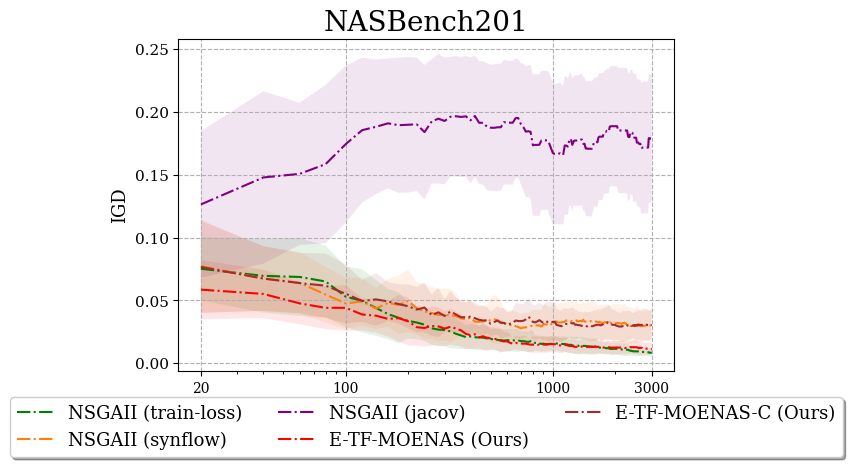

In [8]:
metric = 'IGD'
fig, ax = plt.subplots()
visualize_xaxis_nEvals()

### HV (n_eval)

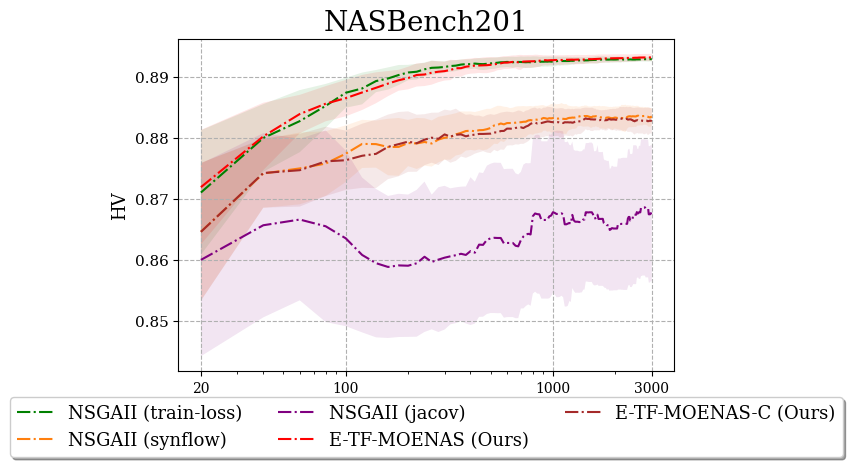

In [9]:
metric = 'HV'
fig, ax = plt.subplots()
visualize_xaxis_nEvals()

### IGD (hours)

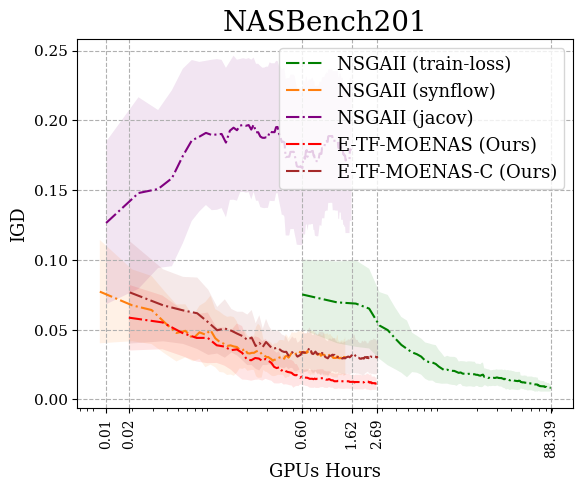

In [10]:
metric = 'IGD'
fig, ax = plt.subplots()
visualize_xaxis_hours()

### HV (hours)

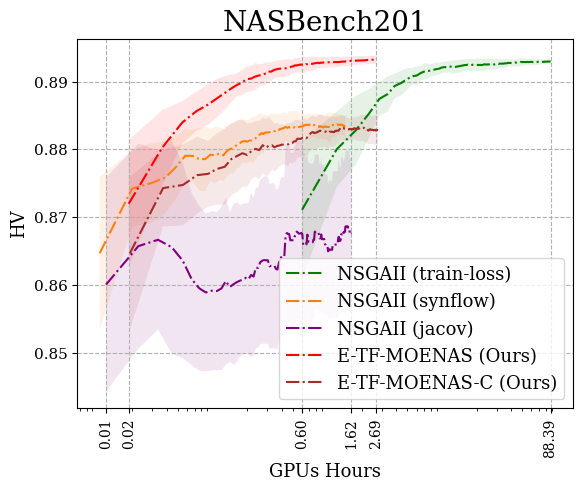

In [11]:
metric = 'HV'
fig, ax = plt.subplots()
visualize_xaxis_hours()

## Run T-tests

In [16]:
run_t_test()

Dataset: CIFAR-10
val_error
IGD: 0.0474 (0.0112)
HV: 0.8891 (0.0013)
Running Time (avg): 276168
Best (mean & std): 93.88 (0.2)
----------------------------------------------------------------------------------------------------
val_loss
IGD: 0.0502 (0.0081)
HV: 0.8885 (0.0012)
Running Time (avg): 278753
Best (mean & std): 93.81 (0.15)
----------------------------------------------------------------------------------------------------
train_loss
IGD: 0.0083 (0.0028)
HV: 0.893 (0.0004)
Running Time (avg): 318207
Best (mean & std): 94.22 (0.03)
----------------------------------------------------------------------------------------------------
moead-val_error
IGD: 0.0572 (0.0202)
HV: 0.8873 (0.0033)
Best (mean & std): 93.72 (0.43)
----------------------------------------------------------------------------------------------------
moead-val_loss
IGD: 0.0692 (0.0343)
HV: 0.8851 (0.006)
Best (mean & std): 93.4 (0.76)
---------------------------------------------------------------------------